## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## Generate synthetic porosity data using the beta distribution

In [2]:
# Set the shape and scale parameters of the beta distribution
shape = 2
scale = 3

# Generate synthetic porosity data using the beta distribution
porosity = beta.rvs(shape, scale, size=1000)

# Add noise to the porosity values
porosity += np.random.normal(loc=0, scale=0.05, size=1000)

# Clip the porosity values to the range [0, 1]
porosity = np.clip(porosity, 0, 1)

# Generate synthetic depth and lithology data
depth = np.random.uniform(low=1000, high=5000, size=1000)
lithology = np.random.choice(['sandstone', 'shale', 'limestone'], size=1000)

## Visualization

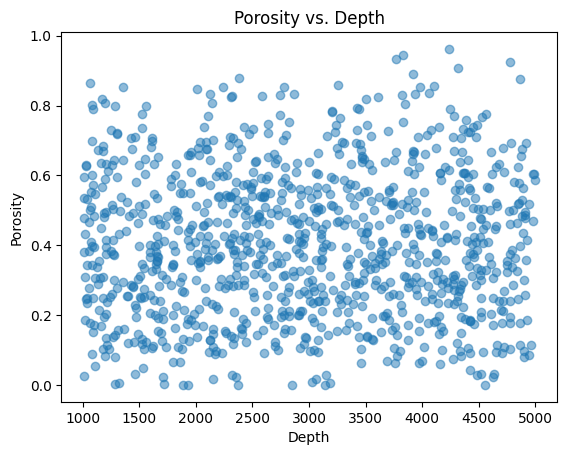

In [3]:
# Plot a scatter plot of porosity vs. depth
plt.scatter(depth, porosity, alpha=0.5)
plt.title("Porosity vs. Depth")
plt.xlabel("Depth")
plt.ylabel("Porosity")
plt.show()

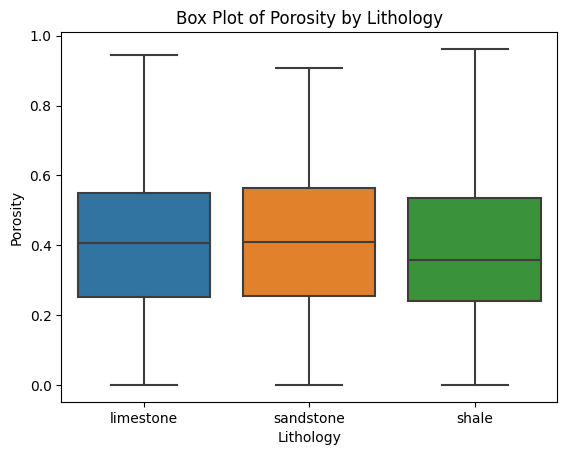

In [4]:
data = pd.DataFrame({'Porosity': porosity, 'Lithology': lithology})
sns.boxplot(x='Lithology', y='Porosity', data=data)
plt.xlabel('Lithology')
plt.ylabel('Porosity')
plt.title('Box Plot of Porosity by Lithology')
plt.show()

## Encode the lithology variable as numeric values 

In [5]:
le = LabelEncoder()
lithology_encoded = le.fit_transform(lithology)

## Split the data into training and test sets

In [6]:
X_train = np.column_stack((depth[:800], lithology_encoded[:800]))
y_train = porosity[:800]
X_test = np.column_stack((depth[800:], lithology_encoded[800:]))
y_test = porosity[800:]

## Define a custom SVR model that incorporates the porosity boundaries

In [7]:
class CustomSVR(BaseEstimator, RegressorMixin):
    
    def __init__(self, kernel='rbf', C=1.0, epsilon=0.1):
        self.kernel = kernel
        self.C = C
        self.epsilon = epsilon
        
    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        self.svr_ = SVR(kernel=self.kernel, C=self.C, epsilon=self.epsilon)
        self.svr_.fit(X, y)
        return self
    
    def predict(self, X):
        y_pred = self.svr_.predict(X)
        for i in range(len(y_pred)):
            if y_pred[i] < 0:
                y_pred[i] = 0
            elif y_pred[i] > 1:
                y_pred[i] = 1
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -custom_cost_function(y, y_pred)

In [8]:
# Define a custom cost function that enforces the porosity boundaries
def custom_cost_function(y_true, y_pred):
    # Compute the mean absolute error between the predicted and actual porosity values
    mae = mean_absolute_error(y_true, y_pred)
    # Penalize the model for exceeding the porosity boundaries
    penalty = 0.0
    for porosity in y_pred:
        if porosity < 0.0:
            penalty += 1.0 - porosity
        elif porosity > 1.0:
            penalty += porosity - 1.0
    return mae + penalty

##  Train the SVR model with the custom cost function

In [9]:
model = CustomSVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X_train, y_train)

CustomSVR()

# Train the SVR model with the custom cost function, Results and Plots

In [10]:
y_pred = model.predict(X_test)

# Compute the mean absolute error between the predicted and actual porosity values
mae = mean_absolute_error(y_test, y_pred)

# Print the mean absolute error
print("Mean absolute error: {:.4f}".format(mae))

Mean absolute error: 0.1763


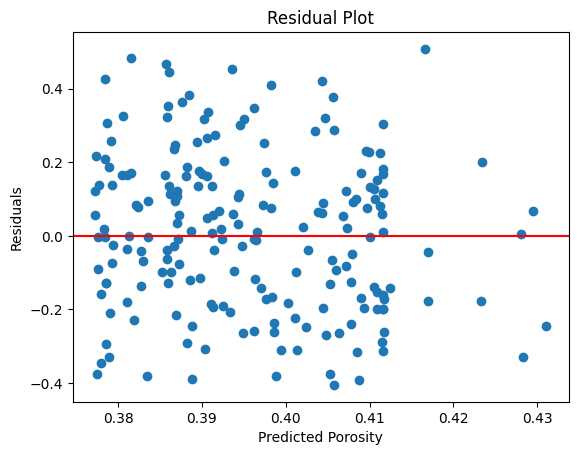

In [11]:
# Compute the residuals
residuals = y_test - y_pred

# Plot the residuals against the predicted porosity
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Porosity")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

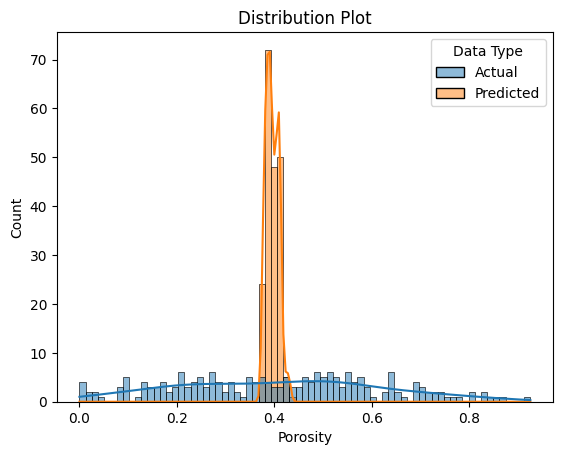

In [12]:
# Create a data frame with the predicted and actual porosity values
data = {"Porosity": np.concatenate((y_test, y_pred)),
        "Data Type": np.concatenate((np.repeat("Actual", len(y_test)),
                                      np.repeat("Predicted", len(y_pred))))}
df = pd.DataFrame(data)

# Plot the distributions
sns.histplot(data=df, x="Porosity", hue="Data Type", kde=True)
plt.xlabel("Porosity")
plt.ylabel("Count")
plt.title("Distribution Plot")
plt.show()